In [6]:
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.animation as animation
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import geopandas as gpd
from Map_Tools import map_elements as me
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar, AnchoredDrawingArea, AnchoredDirectionArrows

from sklearn.model_selection import train_test_split
# Shapes = 'C:\\Users\\User\\Google Drive\\SiteInfo/Ninety/NintyPCT.shp'
Shapes = 'C:\\Users\\User\\Google Drive\\FishIsland_Outputs\\Classification/Training_Data.shp'
Shapes = 'C:\\Users\\User\\Google Drive\\FishIsland_Outputs\\Classification/Three_Class.shp'
Source_Image = 'C:\\Users\\User\\Google Drive\\earthengine/NDVI_Series_BLDP.tif'
Out_Dir = 'C:\\Users\\User\\Google Drive\\FishIsland_Outputs\\Classification/'
# File = 'C:\\Users\\User\\Google Drive\\earthengine/NDVI_Time_Series.tif'

# File = 'C:\\Users\\User\\Google Drive\\earthengine/NDVI_Series_Mean_Mx.tif'


Save_Plots='C:\\Users\\User\\Google Drive\\PhD_Thesis\\Chapter3_Figs/'

%matplotlib notebook


In [7]:

FI_Poly= gpd.read_file('C:\\Users\\User\\Google Drive\\SiteInfo\\FishIsland_Poly.shp')

In [8]:
dst_crs = 'EPSG:32608'

Projected_Image = 'temp/FI_Projected.tif'

with rio.open(Source_Image) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(Projected_Image, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
            

with rio.open(Projected_Image) as src:
    Im = src.read()#[0:fps]
    params = src.profile
    Transform = src.transform

In [10]:
Polys = gpd.read_file(Shapes)
Polys['area'] = Polys.area
# fig,ax=plt.subplots()
shapes = ((geom,value) for geom,value in zip (Polys['geometry'],Polys['Code']))
print(Polys.groupby('Code').sum().area)

with rio.open('temp/Temp_Training.tif','w+',**params) as out:
    out_arr=out.read(1)
    Image=features.rasterize(shapes=shapes,fill=-9999,out=out_arr,transform=Transform)
    out.write(Image,1)
    
#     show(Image,ax=ax,transform=params['transform'])
print(Polys)

Code
2    65279.332062
3    68551.763193
4    67553.971507
Name: area, dtype: float64
    contour      Class  Code  \
0       0.9  Footprint     2   
1       0.0      Levee     3   
2       0.0      Levee     3   
3       0.0      Water     4   
4       0.0      Levee     3   
5       0.0      Levee     3   
6       0.0      Water     4   
7       0.0      Levee     3   
8       0.0      Water     4   
9       0.0      Water     4   
10      0.0      Water     4   
11      0.0      Water     4   
12      0.0      Water     4   
13      0.0      Levee     3   

                                             geometry          area  
0   POLYGON ((504526.102 7695907.136, 504525.931 7...  65279.332062  
1   POLYGON ((504374.349 7696113.931, 504487.431 7...   7031.802720  
2   POLYGON ((504773.686 7696542.051, 504802.342 7...   3915.361504  
3   POLYGON ((503952.281 7695926.861, 504096.676 7...  13406.448735  
4   POLYGON ((503765.122 7695559.791, 503782.628 7...   6143.286054  
5   POLYGON (

In [11]:

# print('Done')

Water = Image.copy()
Water[Water!=4]=np.nan

Levee = Image.copy()
Levee[Levee!=3]=np.nan

Footprint = Image.copy()
Footprint[Footprint!=2]=np.nan

# Degraded = Image.copy()
# Degraded[Degraded!=1]=np.nan

Val = []
Class = []
Year = []


All = []
Yall = []
Call = []

for i,y in enumerate(range(2014,2022)):
    
    All.append(Im[i,~np.isnan(Im[0])])
    Yall.append([y for v in range(Im[i,~np.isnan(Im[0])].shape[0])])
    Call.append([np.nan for v in range(Im[i,~np.isnan(Im[0])].shape[0])])
    
#     Val.append(Im[i,~np.isnan(Degraded)])
#     Class.append([1 for v in range(Im[i,~np.isnan(Degraded)].shape[0])])
#     Year.append([y for v in range(Im[i,~np.isnan(Degraded)].shape[0])])
        
    Val.append(Im[i,~np.isnan(Water)])
    Class.append([4 for v in range(Im[i,~np.isnan(Water)].shape[0])])
    Year.append([y for v in range(Im[i,~np.isnan(Water)].shape[0])])
    
    Val.append(Im[i,~np.isnan(Footprint)])
    Class.append([2 for v in range(Im[i,~np.isnan(Footprint)].shape[0])])
    Year.append([y for v in range(Im[i,~np.isnan(Footprint)].shape[0])])
    
    Val.append(Im[i,~np.isnan(Levee)])
    Class.append([3 for v in range(Im[i,~np.isnan(Levee)].shape[0])])
    Year.append([y for v in range(Im[i,~np.isnan(Levee)].shape[0])])

# print(np.array(Val).shape,np.array(Class).shape)
Sample = pd.DataFrame(data={'Value':[item for sublist in Val for item in sublist],
       'Year':[item for sublist in Year for item in sublist],
       'Class':[item for sublist in Class for item in sublist]})

print(Sample.groupby('Class').count())

FD = pd.DataFrame(data={'Value':[item for sublist in All for item in sublist],
       'Year':[item for sublist in Yall for item in sublist],
       'Class':[item for sublist in Call for item in sublist]})

# print(Im*Degraded)

Reform = Sample.loc[Sample['Year']==2014,['Value','Class']].copy()
Reform_Big = FD.loc[FD['Year']==2014,['Value','Class']].copy()
Reform=Reform.rename(columns={'Value':2014})
Reform_Big=Reform_Big.rename(columns={'Value':2014})
for y in range(2015,2022):
    Reform[['Value']] = Sample.loc[Sample['Year']==y,['Value']].values
    Reform=Reform.rename(columns={'Value':y})
    
    
    Reform_Big[['Value']] = FD.loc[FD['Year']==y,['Value']].values
    Reform_Big=Reform_Big.rename(columns={'Value':y})
    
Reform_Big.columns


       Value  Year
Class             
2       2488  2488
3       2664  2664
4       2640  2640


Index([2014, 'Class', 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='object')

# Classify

In [12]:

X_train, X_test, y_train, y_test = train_test_split(Reform[[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]], 
                                                    Reform['Class'],
#                                                     stratify=Reform['Class'],
                                                    test_size=0.33, random_state=9)
print('Done')
print(y_train.value_counts())


clf = RandomForestClassifier(random_state=55,min_samples_leaf=30)#,bootstrap=False)
clf = clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

y_pred_test = clf.predict(X_test)
print(confusion_matrix(y_test.values, y_pred_test))

print()
print(classification_report(y_test, y_pred_test))

Done
4    223
3    222
2    207
Name: Class, dtype: int64
0.9627329192546584
[[104   0   0]
 [  8 101   2]
 [  2   0 105]]

              precision    recall  f1-score   support

           2       0.91      1.00      0.95       104
           3       1.00      0.91      0.95       111
           4       0.98      0.98      0.98       107

    accuracy                           0.96       322
   macro avg       0.96      0.96      0.96       322
weighted avg       0.97      0.96      0.96       322



In [13]:

Reform_Big['Class']=clf.predict(Reform_Big[[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]].values)

Classes = Im[0].copy()*np.nan


# for i,y in enumerate(range(2014,2022)):
Classes=Reform_Big['Class'].astype(int).values.reshape(-1,Im.shape[-1])

print(Im.shape)
FD[['Value','Year']]
print(Classes)
out_prams = params.copy()
out_prams['count']=1
with rio.open(Out_Dir+'FI_LC_Class_Final.tif','w+',**out_prams) as out:
    out.write(Classes,1)

(8, 3483, 3325)
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]


In [14]:
# plt.figure()
with rio.open('temp/BLDP_Mask.tif','r') as src:
    BL_Mask = src.read()
    BL = Classes*BL_Mask
# #     show(BL)
#     print(BL.shape)
    
    with rio.open(Out_Dir+'FI_LC_Class_Maked.tif','w+',**out_prams) as out:
        out.write(BL)
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            features.shapes(Image, mask=None, transform=src.transform)))
    
geoms = list(results)
Temp = gpd.GeoDataFrame.from_features(geoms)
BLDP = Temp.loc[Temp['raster_val']>0].copy()#

Bad = BLDP[BLDP.geometry.is_valid==False].buffer(0)
BLDP.loc[BLDP.geometry.is_valid==False,'geometry']=Bad.geometry
BLDP = BLDP.dropna().dissolve(by='raster_val').reset_index()


In [15]:
BLDP.crs=FI_Poly.crs
BLDP.to_file(Out_Dir+'Big_Lake_Plain_Classified.shp')
BLDP.loc[BLDP['raster_val']==2].to_file(Out_Dir+'Big_Lake_Plain_LCP.shp')

<IPython.core.display.Javascript object>


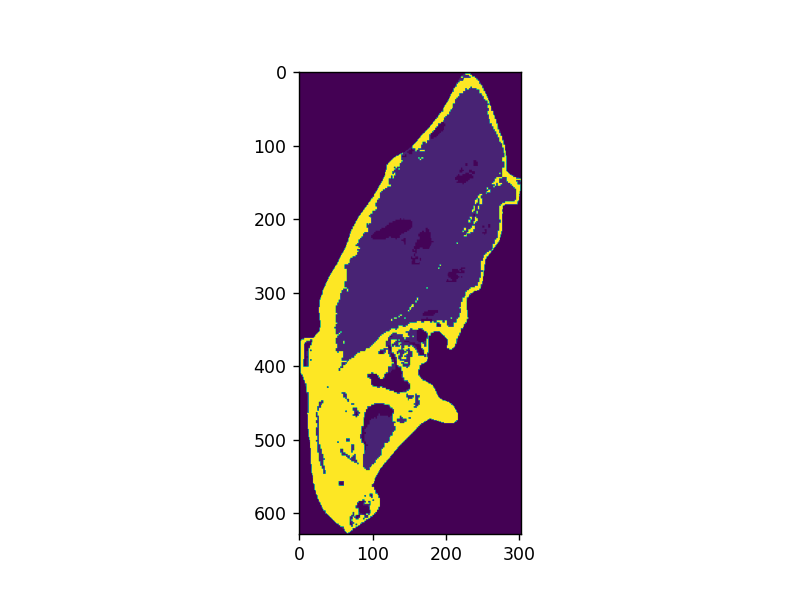

X,Y
14.44983049595372 14.44983049595372
area
208.7976013617941

1.0
0.062 1.18

10.0
0.546 10.45

100.0
0.392 7.51



In [149]:


CL = ['#d1f5b0','#28c71e','#1f78b4']
# LL = ['LCP','LUA','OWA']
LL = ['Low Center Polygons','Shub Tundra','Open Water']

fig = plt.figure()
import rasterio.mask
# with rio.open(Out_Dir + "FI_LC_Class_Final.tif") as src:
with rio.open(Out_Dir+'KM_class_final.tif') as src:
    
    out_image, out_transform = rasterio.mask.mask(src, FI_Poly.geometry, crop=True)
    gt = src.transform
    show(out_image)
    pixelSizeX = gt[0]
    pixelSizeY =-gt[4]
    
    print('X,Y')
    print(pixelSizeX,pixelSizeY)
    print('area')
    area = (pixelSizeX*pixelSizeY)
    print(area)

    (unique, counts) = np.unique(out_image, return_counts=True)
    # print(LL, counts[1:], np.round(counts[1:]/counts[1:].sum(),2))
    print()

#     for cl, px in zip(LL,counts[1:]):
    for cl, px in zip(unique[1:], counts[1:]):
        print(cl)
        print(np.round(px/counts[1:].sum(),3),np.round(px*area/1e6,2))
        print()

#     Image=src.read()
#     print(Image)
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            features.shapes(out_image, mask=None, transform=out_transform)))
# print(results)  
geoms = list(results)
Temp = gpd.GeoDataFrame.from_features(geoms)
Temp.crs = FI_Poly.crs
FI = Temp.loc[Temp['raster_val']>0].copy()#

Bad = FI[FI.geometry.is_valid==False].buffer(0)
FI.loc[FI.geometry.is_valid==False,'geometry']=Bad.geometry
FI = FI.dropna().dissolve(by='raster_val').reset_index()


<IPython.core.display.Javascript object>


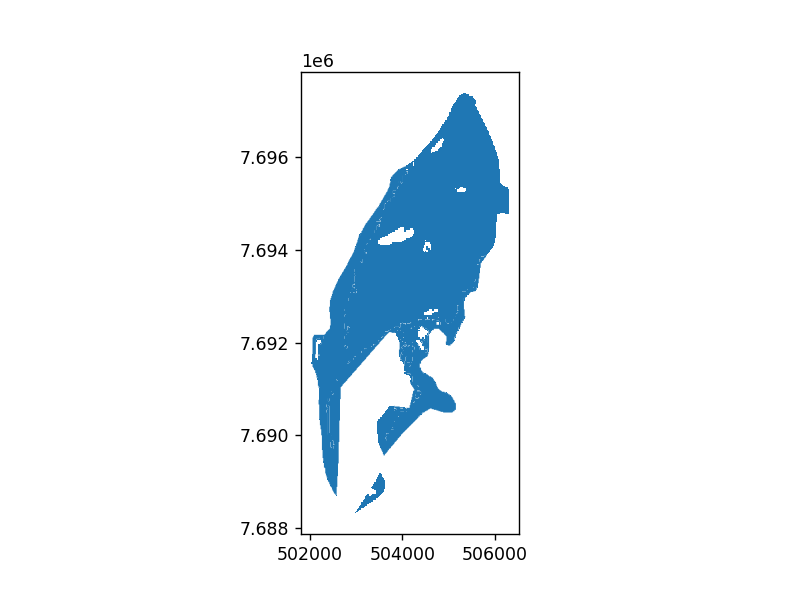

<AxesSubplot:>

In [18]:
FI.crs = FI_Poly.crs
# FI.crs
FI.to_file(Out_Dir+'Fish_Island_Classified.shp')
FI.loc[FI['raster_val']==2].to_file(Out_Dir+'Fish_Island_LCP.shp')

# with rio.open(Out_Dir+'FI_LC_Class_Final.tif','r') as out:
#     Classes=out.read()
#     params=out.profile
# #     show(Classes,cmap=cmap,norm=norm,ax=ax[0],transform=params['transform'])
# #     show(Classes,cmap=cmap,norm=norm,ax=ax[1],transform=params['transform'])
# print(Classes.max())

FI.plot()#Ecolumns='raster_val')

   raster_val                                           geometry
0         2.0  MULTIPOLYGON (((503117.307 7688410.765, 503102...
1         3.0  MULTIPOLYGON (((503001.709 7688324.066, 502987...
2         4.0  MULTIPOLYGON (((503319.605 7688555.263, 503319...


<IPython.core.display.Javascript object>


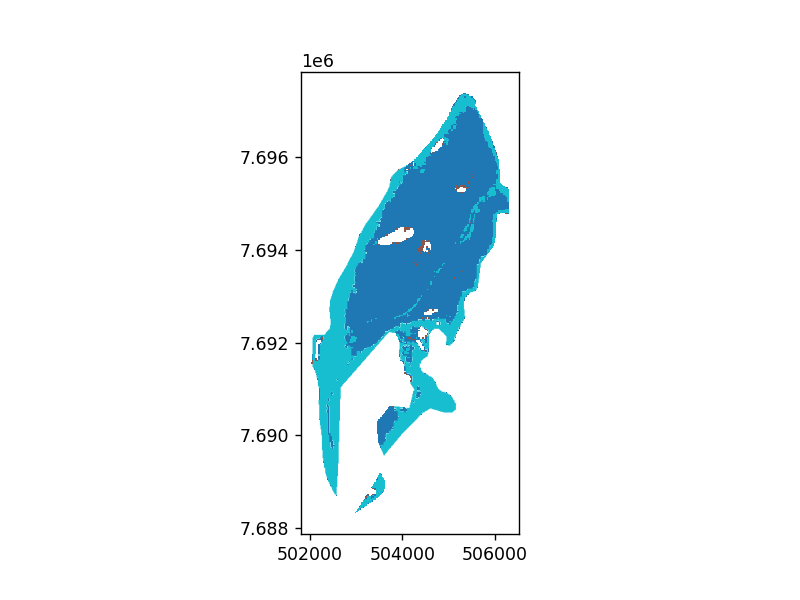

<AxesSubplot:>

In [19]:
print(FI)
raster_val = [2.0,3.0,4.0]

CL = ['#d1f5b0','#28c71e','#1f78b4']
# LL = ['LCP','LUA','OWA']
LL = ['Low Center Polygons','Shub Tundra','Open Water']

for v,c in zip(raster_val,LL):
    FI.loc[FI['raster_val']==v,'Class']=c
# print(FI)
FI.plot(column='Class')

In [73]:

x_buff = 5e2
y_buff = 5e2

xl = [FI_Poly.bounds['minx'].values[0]-x_buff,FI_Poly.bounds['maxx'].values[0]+x_buff]
yl = [FI_Poly.bounds['miny'].values[0]-y_buff,FI_Poly.bounds['maxy'].values[0]+y_buff]

XB = [xl[0],xl[0],xl[1],xl[1],xl[0]]
YB = [yl[0],yl[1],yl[1],yl[0],yl[0]]

from shapely.geometry import Polygon
polygon_geom = Polygon(zip(XB, YB))
BB = gpd.GeoDataFrame(index=[0], crs=FI_Poly.crs, geometry=[polygon_geom])
# BB = BB.to_crs('WGS1984')
BB.to_file('temp/BoundingBox.shp')
print(BB)
# XB = [XL[0],XL[0],XL[1],XL[1],XL[0]]
# YB = [YL[0],YL[1],YL[1],YL[0],YL[0]]
# print(YB)


                                            geometry
0  POLYGON ((501537.684 7687818.790, 501537.684 7...


<IPython.core.display.Javascript object>


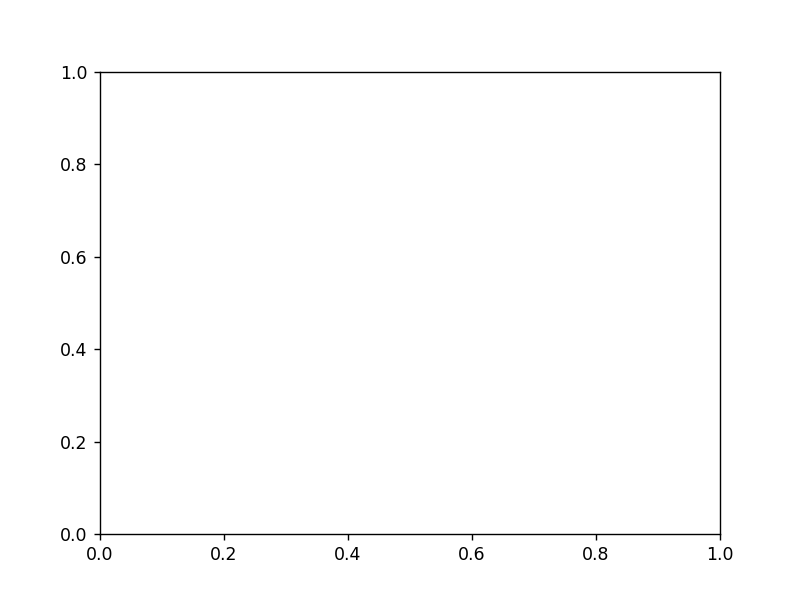

In [104]:
# plt.figure()
# 
# fig,ax=plt.subplots()
with rio.open(Projected_Image) as src:
    out_image, out_transform = rasterio.mask.mask(src, BB.geometry, crop=True)
    gt = src.transform
    Temp = out_image.reshape(8,-1).T
#     KM = out_image[out_image>0].reshape(8,-1).T
# Temp
# print(Temp.shape,out_image.shape)
    kmeans = KMeans(n_clusters=6, random_state=0).fit(Temp)
    Lbls = kmeans.labels_.reshape(out_image.shape[1],-1)
    with rio.open(
            'temp/KM_class.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=1,
            crs = src.crs,
            width=out_image.shape[2],
            height=out_image.shape[1],
            transform=out_transform,
        ) as dst:
        dst.write(Lbls,1)

<IPython.core.display.Javascript object>


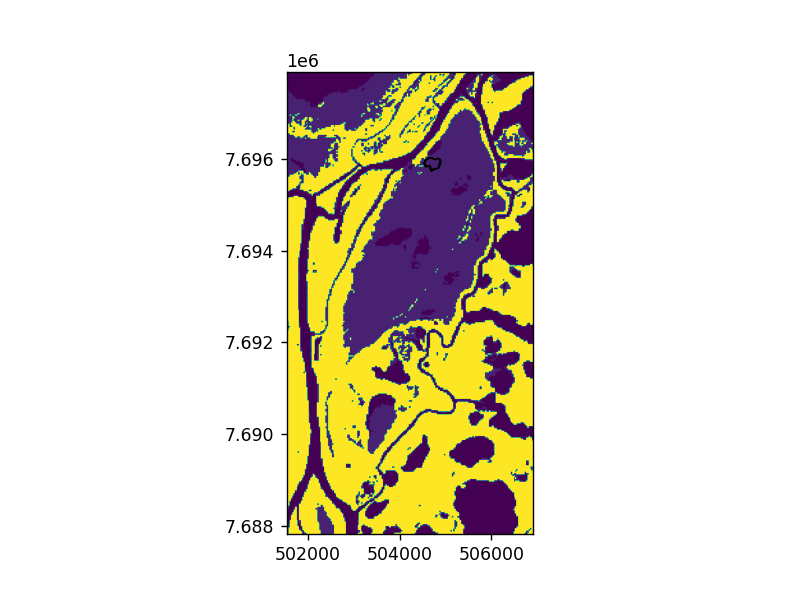

(1, 698, 373)


In [110]:
fig,ax=plt.subplots()
with rio.open(
        'temp/KM_class.tif', 'r',
    ) as src:
#     dst.write(Lbls,1)
    Lbls = src.read()
    Class = Lbls.copy()
    Classes = {
        5:10,
        4:100,
        3:1,
        2:1,
        1:100,
        0:1,
    }
    for c in Classes.keys():
#         print(c,Classes[c])
        Class[Lbls==c] = Classes[c]
    
    show(Class,ax=ax,transform=src.transform)
    FP.loc[FP.contour == 0.9].plot(ax=ax,facecolor='None',edgecolor='k',
                                   label='90% Footprint',
                                  )
    with rio.open(
            Out_Dir+'KM_class_final.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=1,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        print(Class.shape)
        dst.write(Class)#,1)

# K means

<IPython.core.display.Javascript object>


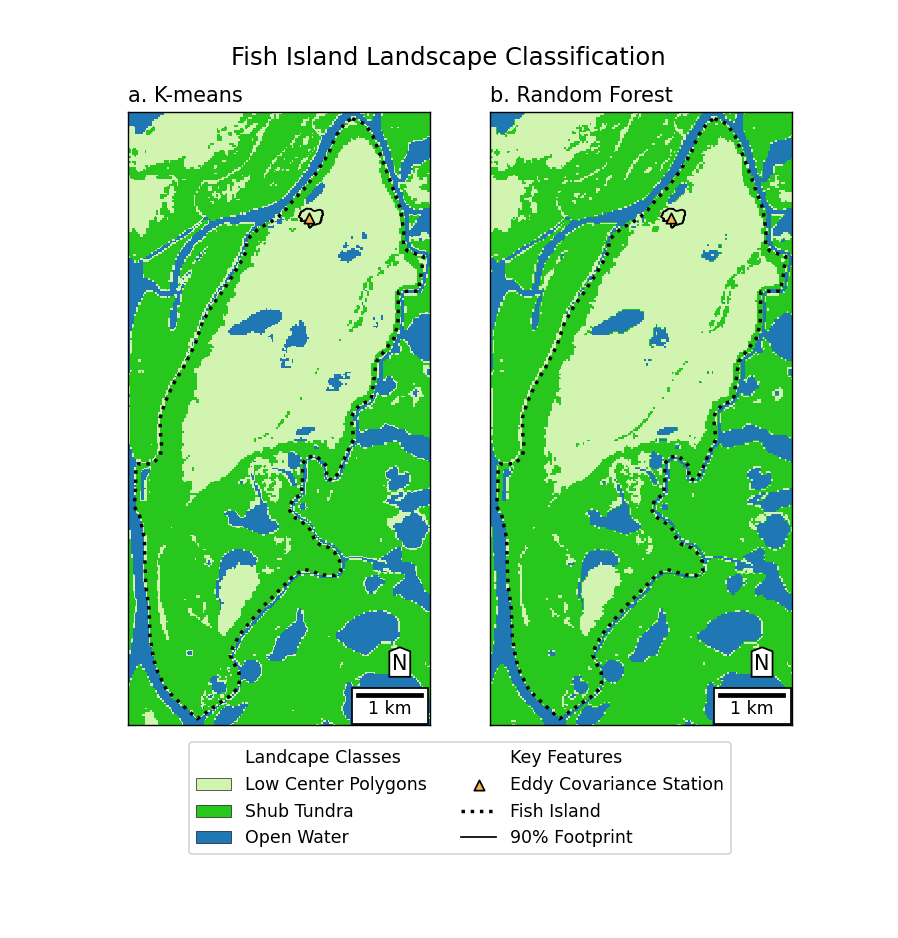

   id         Name        Label                     geometry
0   1   EC Station           EC  POINT (-134.88098 69.37234)
1  99  Taglu Tower  Taglu Tower  POINT (-134.88782 69.37103)
2  68           S1           S1  POINT (-134.88132 69.37227)
3  69           PS           PS  POINT (-134.88115 69.37226)
4  99           S2           S2  POINT (-134.88121 69.37219)
5  56           S3           S3  POINT (-134.88120 69.37210)
6  96          AWS          AWS  POINT (-134.88210 69.37219)
0.4929649314378287
[504179.3012938964, 504179.3012938964, 505179.3012938964, 505179.3012938964, 504179.3012938964] [7694871.463316225, 7696900.005178389, 7696900.005178389, 7694871.463316225, 7694871.463316225]


In [140]:


x_buff = 1e2
y_buff = 1e2


CL = ['#1f78b4','#d1f5b0','#28c71e']
# LL = ['LCP','LUA','OWA']
LL = ['Open Water','Low Center Polygons','Shub Tundra']

cmap = colors.ListedColormap(CL)
# bounds=[.5,2.5,3.5,4.5]

# bounds=[.5,2.5,3.5,4.5]
bounds=[.5,2.5,30.5,400.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

params['count']=1
params['dtype']=rio.uint8

fig = plt.figure(figsize=(5.75,6))#5.25))

gs = GridSpec(100, 100, figure=fig)
ax1 = fig.add_subplot(gs[0:85, :48])
ax2 = fig.add_subplot(gs[0:85, 52:])

ax3 = fig.add_subplot(gs[90:, :])

ax = [ax1,ax2,ax3]

FP_Line = 1
FP_Style = '-'

FI_Style = {'linestyle':':',
            'linewidth':2}

with rio.open(Out_Dir+'KM_class_final.tif','r') as out:
    Classes=out.read()
    params=out.profile
    show(Classes,cmap=cmap,norm=norm,ax=ax[0],transform=params['transform'])
#     show(Classes,cmap=cmap,norm=norm,ax=ax[1],transform=params['transform'])
    
CL = ['#d1f5b0','#28c71e','#1f78b4']
LL = ['Low Center Polygons','Shub Tundra','Open Water']
    
cmap = colors.ListedColormap(CL)
bounds=[.5,2.5,3.5,4.5]
# bounds=[.5,2.5,30.5,400.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

with rio.open(Out_Dir+'FI_LC_Class_Final.tif','r') as out:
    Classes=out.read()
    params=out.profile
#     show(Classes,cmap=cmap,norm=norm,ax=ax[0],transform=params['transform'])
    show(Classes,cmap=cmap,norm=norm,ax=ax[1],transform=params['transform'])
    
    
# FI_Poly= gpd.read_file('C:\\Users\\User\\Google Drive\\SiteInfo\\FishIsland_Poly.shp')
FI_Poly.plot(ax=ax[0],facecolor='None',edgecolor='k',label='Fish Island',**FI_Style)
ax[0].plot([],[],color='k',label='Fish Island',**FI_Style)
FP.loc[FP.contour == 0.9].plot(ax=ax[0],facecolor='None',edgecolor='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)

# Polys.plot(ax=ax[0],facecolor='None',edgecolor='k')

# x_buff = 2e3
# y_buff = 1e3

ax[0].set_xlim(FI_Poly.bounds['minx'].values[0]-x_buff,FI_Poly.bounds['maxx'].values[0]+x_buff)
ax[0].set_ylim(FI_Poly.bounds['miny'].values[0]-y_buff,FI_Poly.bounds['maxy'].values[0]+y_buff)

FP = gpd.read_file('C:\\Users\\User\\Google Drive\\SiteInfo\\2000mx2m_Climatology.shp')
# FP.loc[FP.contour == 0.9].plot(ax=ax[0],facecolor='None',edgecolor='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)
# ax[0].plot([np.nan],[np.nan],color='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

pt=gpd.read_file(Out_Dir+'Points.shp')
print(pt)
POI = pt.to_crs(FI_Poly.crs)

ms = 35

FI_Poly.plot(ax=ax[1],facecolor='None',edgecolor='k',label='Fish Island',**FI_Style)
FP.loc[FP.contour == 0.9].plot(ax=ax[1],facecolor='None',edgecolor='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)

POI.loc[POI['Name']=='EC Station'].plot(ax=ax[0],marker='^',facecolor='#feb24c',edgecolor='k',markersize=ms)
POI.loc[POI['Name']=='EC Station'].plot(ax=ax[1],marker='^',facecolor='#feb24c',edgecolor='k',markersize=ms)
# POI.loc[POI['Name']=='AWS'].plot(ax=ax[1],marker='^',facecolor='#feb24c',edgecolor='k',markersize=ms)
# POI.loc[POI['Name']=='Taglu Tower'].plot(ax=ax[1],marker='*',facecolor='#feb24c',edgecolor='k',markersize=ms)

xl = ax[0].get_xlim()
yl = ax[0].get_ylim()

ar = (xl[0]-xl[1])/(yl[0]-yl[1])
print(ar)
# ar=.7


CP_x = (POI.loc[POI['Name']=='EC Station'].geometry.x[0])
CP_y = (POI.loc[POI['Name']=='EC Station'].geometry.y[0])

X_Scale = 1000

ax[1].set_xlim(FI_Poly.bounds['minx'].values[0]-x_buff,FI_Poly.bounds['maxx'].values[0]+x_buff)
ax[1].set_ylim(FI_Poly.bounds['miny'].values[0]-y_buff,FI_Poly.bounds['maxy'].values[0]+y_buff)

# XB = [XL[0],XL[0],XL[1],XL[1],XL[0]]
# YB = [YL[0],YL[1],YL[1],YL[0],YL[0]]


# ax[0].plot(XB,YB,color='k')
# ax[1].plot([],[],color='k',label='Extent Indicator (b.)')

# ax[1].plot([],[],color='None',label='')
ax[1].scatter([],[],label='Eddy Covariance Station',marker='^',facecolor='#feb24c',edgecolor='k',s=ms)
ax[1].plot([np.nan],[np.nan],color='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)
ax[1].plot([],[],color='k',label='Fish Island',**FI_Style)

# ax[0].scatter([],[],label='Eddy Covariance Station',marker='^',facecolor='#feb24c',edgecolor='k',s=ms)

print(XB,YB)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)


me.scalebar(ax[0],distance=1e3,label='1 km',pos='lower right')
me.North_Arrow(ax[0],x=0.9,y=0.1)

me.scalebar(ax[1],distance=1e3,label='1 km',pos='lower right')
me.North_Arrow(ax[1],x=0.9,y=0.1)


Combined_Patches=[]
kwargs = {'facecolor':'None',
         'edgecolor':'None',
         'linewidth':.35,
         'label':'Landcape Classes'}
Combined_Patches.append(mpatches.Patch(**kwargs))

for c,l in zip(CL,LL):
    kwargs = {'facecolor':c,
             'edgecolor':'black',
             'linewidth':.35,
             'label':l}
    Combined_Patches.append(mpatches.Patch(**kwargs))


kwargs = {'facecolor':'None',
         'edgecolor':'None',
         'linewidth':.35,
         'label':'Key Features'}
Combined_Patches.append(mpatches.Patch(**kwargs))

handles, labels = ax[1].get_legend_handles_labels()
    

for h in handles[::-1]:
    Combined_Patches.append(h)

ax[2].legend(ncol=2,handles=(Combined_Patches), loc='center')
ax[2].axis('off')

plt.suptitle('Fish Island Landscape Classification',fontsize=14,y=.95)

ax[0].set_title('a. K-means',loc='left')
ax[1].set_title('b. Random Forest',loc='left')

# plt.tight_layout()

plt.savefig(Save_Plots+'LCM.png',dpi=400,bbox_inches='tight', pad_inches=0.05)
plt.savefig('C:\\Users\\User\\GEOS270\\Module3\\docs\\content\\images/LCM.png',dpi=400,bbox_inches='tight', pad_inches=0)

unique, counts = np.unique(Lbls, return_counts=True)

print(unique,counts/counts.sum())

<IPython.core.display.Javascript object>


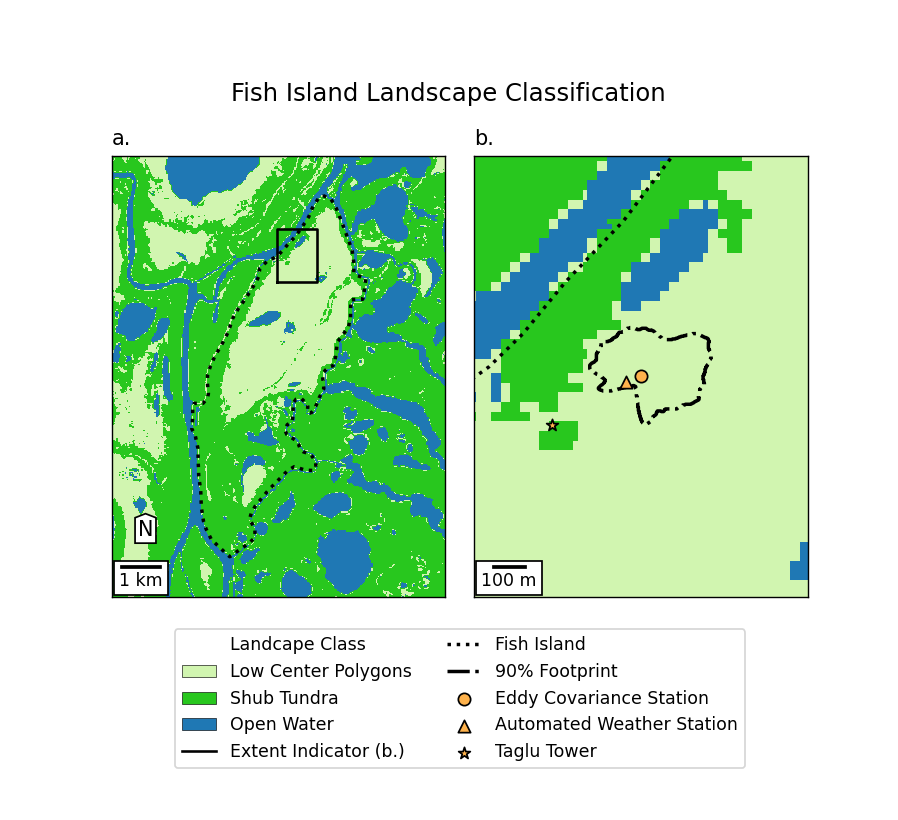

   id         Name        Label                     geometry
0   1   EC Station           EC  POINT (-134.88098 69.37234)
1  99  Taglu Tower  Taglu Tower  POINT (-134.88782 69.37103)
2  68           S1           S1  POINT (-134.88132 69.37227)
3  69           PS           PS  POINT (-134.88115 69.37226)
4  99           S2           S2  POINT (-134.88121 69.37219)
5  56           S3           S3  POINT (-134.88120 69.37210)
6  96          AWS          AWS  POINT (-134.88210 69.37219)
0.7560256728880387
[504179.3012938964, 504179.3012938964, 505179.3012938964, 505179.3012938964, 504179.3012938964] [7695224.381044724, 7696547.087449891, 7696547.087449891, 7695224.381044724, 7695224.381044724]


In [141]:
# CL = ['#b59f33', '#d1f5b0','#28c71e','#1f78b4']
# LL = ['DLP','LCP','LUA','OWA']
# LL = ['Degraded Polygons','Low Center Polygons','Shub Tundra','Open Water']


CL = ['#d1f5b0','#28c71e','#1f78b4']
LL = ['LCP','LUA','OWA']
LL = ['Low Center Polygons','Shub Tundra','Open Water']

cmap = colors.ListedColormap(CL)
bounds=[.5,2.5,3.5,4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)


# clf.score(Sample[['Value','Year']], Sample['Class'])
# print(params)
params['count']=1
params['dtype']=rio.uint8
# fig,ax=plt.subplots(1,2,figsize=(7.5,5))


# fig,ax=plt.subplots(1,3,figsize=(7,4.75))

fig = plt.figure(figsize=(5.75,5.25))

gs = GridSpec(100, 100, figure=fig)
ax1 = fig.add_subplot(gs[0:88, :48])
ax2 = fig.add_subplot(gs[0:88, 52:])

ax3 = fig.add_subplot(gs[90:, :])

ax = [ax1,ax2,ax3]

FP_Line = 2
FP_Style = '-.'

FI_Style = {'linestyle':':',
            'linewidth':2}



with rio.open(Out_Dir+'FI_LC_Class_Final.tif','r') as out:
    Classes=out.read()
    params=out.profile
    show(Classes,cmap=cmap,norm=norm,ax=ax[0],transform=params['transform'])
    show(Classes,cmap=cmap,norm=norm,ax=ax[1],transform=params['transform'])
    
    
# FI_Poly= gpd.read_file('C:\\Users\\User\\Google Drive\\SiteInfo\\FishIsland_Poly.shp')
FI_Poly.plot(ax=ax[0],facecolor='None',edgecolor='k',label='Fish Island',**FI_Style)
ax[0].plot([],[],color='k',label='Fish Island',**FI_Style)

# Polys.plot(ax=ax[0],facecolor='None',edgecolor='k')

x_buff = 2e3
y_buff = 1e3

ax[0].set_xlim(FI_Poly.bounds['minx'].values[0]-x_buff,FI_Poly.bounds['maxx'].values[0]+x_buff)
ax[0].set_ylim(FI_Poly.bounds['miny'].values[0]-y_buff,FI_Poly.bounds['maxy'].values[0]+y_buff)

FP = gpd.read_file('C:\\Users\\User\\Google Drive\\SiteInfo\\2000mx2m_Climatology.shp')
# FP.loc[FP.contour == 0.9].plot(ax=ax[0],facecolor='None',edgecolor='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)
# ax[0].plot([np.nan],[np.nan],color='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

pt=gpd.read_file(Out_Dir+'Points.shp')
print(pt)
POI = pt.to_crs(FI_Poly.crs)

ms = 50

FI_Poly.plot(ax=ax[1],facecolor='None',edgecolor='k',label='Fish Island',**FI_Style)
FP.loc[FP.contour == 0.9].plot(ax=ax[1],facecolor='None',edgecolor='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)

POI.loc[POI['Name']=='EC Station'].plot(ax=ax[1],marker='o',facecolor='#feb24c',edgecolor='k',markersize=ms)
POI.loc[POI['Name']=='AWS'].plot(ax=ax[1],marker='^',facecolor='#feb24c',edgecolor='k',markersize=ms)
POI.loc[POI['Name']=='Taglu Tower'].plot(ax=ax[1],marker='*',facecolor='#feb24c',edgecolor='k',markersize=ms)

xl = ax[0].get_xlim()
yl = ax[0].get_ylim()

ar = (xl[0]-xl[1])/(yl[0]-yl[1])
print(ar)
# ar=.7


CP_x = (POI.loc[POI['Name']=='EC Station'].geometry.x[0])
CP_y = (POI.loc[POI['Name']=='EC Station'].geometry.y[0])

X_Scale = 1000

XL=[CP_x-X_Scale/2,CP_x+X_Scale/2]
YL=[CP_y-(X_Scale/2)*(1/ar),CP_y+(X_Scale/2)*(1/ar)]
ax[1].set_xlim(XL)
ax[1].set_ylim(YL)


XB = [XL[0],XL[0],XL[1],XL[1],XL[0]]
YB = [YL[0],YL[1],YL[1],YL[0],YL[0]]


ax[0].plot(XB,YB,color='k')
ax[1].plot([],[],color='k',label='Extent Indicator (b.)')

ax[1].plot([],[],color='None',label='')

ax[1].plot([],[],color='k',label='Fish Island',**FI_Style)

ax[1].plot([np.nan],[np.nan],color='k',label='90% Footprint',linestyle=FP_Style,linewidth=FP_Line)


ax[1].scatter([],[],label='Eddy Covariance Station',marker='o',facecolor='#feb24c',edgecolor='k',s=ms)
ax[1].scatter([],[],label='Automated Weather Station',marker='^',facecolor='#feb24c',edgecolor='k',s=ms)
ax[1].scatter([],[],label='Taglu Tower',marker='*',facecolor='#feb24c',edgecolor='k',s=ms)


print(XB,YB)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)


me.scalebar(ax[0],distance=1e3,label='1 km')
me.scalebar(ax[1],distance=1e2,label='100 m')

me.North_Arrow(ax[0],x=0.1,y=0.15)


Combined_Patches=[]
kwargs = {'facecolor':'None',
         'edgecolor':'None',
         'linewidth':.35,
         'label':'Landcape Class'}
Combined_Patches.append(mpatches.Patch(**kwargs))
for c,l in zip(CL,LL):
    kwargs = {'facecolor':c,
             'edgecolor':'black',
             'linewidth':.35,
             'label':l}
    Combined_Patches.append(mpatches.Patch(**kwargs))


handles, labels = ax[1].get_legend_handles_labels()
for h in handles[:1]:
    Combined_Patches.append(h)
    
# kwargs = {'facecolor':'None',
#          'edgecolor':'None',
#          'linewidth':.35,
#          'label':'Points of Interest'}
# Combined_Patches.append(mpatches.Patch(**kwargs))


for h in handles[1:]:
    Combined_Patches.append(h)

ax[2].legend(ncol=2,handles=(Combined_Patches), loc='center')
ax[2].axis('off')

plt.suptitle('Fish Island Landscape Classification',fontsize=14,y=.90)

ax[0].set_title('a.',loc='left')
ax[1].set_title('b.',loc='left')

# plt.tight_layout()

plt.savefig(Save_Plots+'LCM.png',dpi=400,bbox_inches='tight', pad_inches=0.05)
plt.savefig('C:\\Users\\User\\GEOS270\\Module3\\docs\\content\\images/LCM.png',dpi=400,bbox_inches='tight', pad_inches=0)